In [1]:
import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

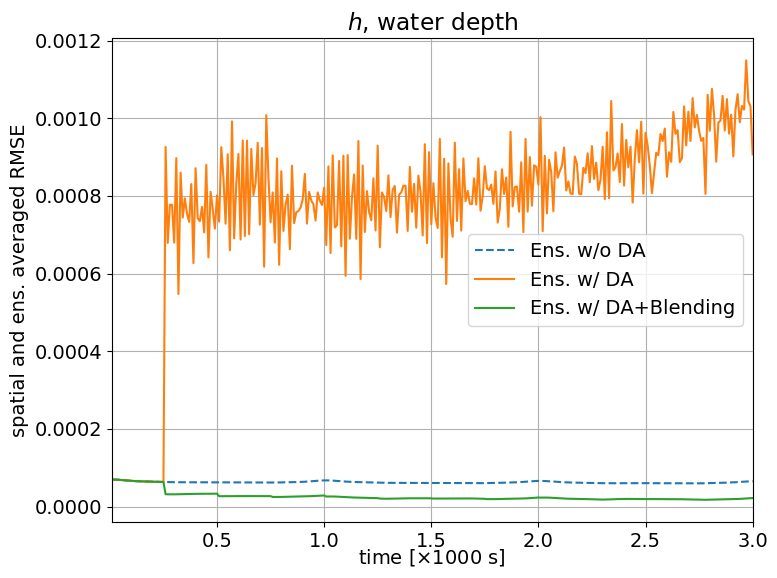

In [21]:
import matplotlib.pyplot as plt

base_fn = "output_swe_vortex"
directory = "output_swe_vortex"
py_directory = "../%s/" %directory

et = 3.0
Nx, Ny, Nz = 64, 1, 64
swe_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)

# base_fn = "output_travelling_vortex"
# directory = "output_travelling_vortex"
# py_directory = "../%s/" %directory

# Nx, Ny = 64, 64
# euler_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

py_directory = "../%s/" %directory

plt.style.use('default')

N = 10
print_mems = False
times = np.arange(0.0,3.01,0.01)[1:]

probe_idx = [32,32]

fn = 'effects_obs_covar_ensemble_spread'
title = ''

swe = True if 'swe' in base_fn else False
tc = swe_tc if swe else euler_tc
        
prt = utils.prt_time(debug=False)
if swe:
    attr_labels = pt.swe_labels()
    attributes = ['rho','p2_nodes','rhou','rhow']
    attributes = ['rho']
else:
    attr_labels = pt.labels()
    attributes = ['rhoY','p2_nodes','rhou','rhov']
    attributes = ['rhoY']

if len(attributes) == 2:
    fs = (16,6)
    nrows = 1
elif len(attributes) == 1:
    if print_mems:
        fs = (16,30)
        nrows = 5+1
        ncols = 2
    else:
        fs = (8,6)
        nrows = 1
        ncols = 1
else:
    fs = (16,14)
    nrows = 2
pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=ncols,nrows=nrows)

rmse_type = 'spatial'

typ = 'pos'
ens_34 = False

def get_ens(sfx,diff):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type='TIME', avg=False, diff=diff)[1:]
    if swe:
        ens = ens[:,:,:,0,:]
    return ens

for i,attribute in enumerate(attributes):
    diff = False if attribute == 'p2_nodes' else False
    gt = 'n' if attribute == 'p2_nodes' else 'c'
    
    if swe:
        ens_noda_suffix = 'pp_tra_ip_nonorm_ib-0'
    else:
        ens_noda_suffix = 'debug_%s_noda_ib-0' %typ
#         ens_noda_suffix = 'noda_homen_ib-0'
    ens_noda_label = 'Ens. w/o DA'
    ens_noda = get_ens(ens_noda_suffix, diff)
    
    obs_attrs = 'rhou_rhow' if swe else 'rhou_rhov'
    tags = 's10p'
    if swe:
        ens_1_suffix = 'wdawloc_%s_debug_letkf_%s_ib-0' %(obs_attrs,tags)
#         ens_1_suffix = 'wdawloc_%s_wda_ib-0' %(obs_attrs)
    else:
        ens_1_suffix = 'wdawloc_%s_debug_%s_%s_ib-0' %(obs_attrs,typ, tags)
#         ens_1_suffix = 'wdawloc_%s_wda_homen_ib-0' %(obs_attrs)
    ens_1_label = r'EnDA'
    ens_1_label = r'Ens. w/ DA'
    
    ens_2_suffix = tc.cb_suffix(1,0, '%s' %(ens_1_suffix))
    ens_2_label = r'EnDAB'
    ens_2_label = r'Ens. w/ DA+Blending'

    ens_1 = get_ens(ens_1_suffix, diff)
    ens_2 = get_ens(ens_2_suffix, diff)
    
    if ens_34:
        ens_3_label = (ens_1_label)
        ens_4_label = (ens_2_label)
        ens_1_label += ' %s' %typ
        ens_2_label += ' %s' %typ
        
        obs_attrs = 'rhou_rhov'
        tags = 's10p'
        ens_3_suffix = 'wdawloc_%s_pp_tra_ip_nonorm_ib-0' %obs_attrs
#         ens_3_suffix = 'wdawloc_%s_debug_pos_%s_ib-0' %(obs_attrs,tags)
        ens_4_suffix = tc.cb_suffix(1,0, '%s' %(ens_3_suffix))

        ens_3_label += ' pos'
        ens_4_label += ' pos'
        
        ens_3 = get_ens(ens_3_suffix, diff)
        ens_4 = get_ens(ens_4_suffix, diff)

#     print(ens_2.shape)
    
    obs = tc.get_ensemble(times, 1, attribute, 'comp_1.0_pp_tra_truth_ip', label_type='TIME',avg=True, diff=diff)
    truth = tc.get_ensemble(times, 1, attribute, 'truth_ib-0', label_type='TIME',avg=True, diff=diff)
#     truth = tc.get_ensemble(times, 1, attribute, 'comp_1.0_pp_tra_truth_ip_ib-0', label_type='TIME',avg=True, diff=diff)
    truth_pos = tc.get_ensemble(times, 1, attribute, 'comp_1.0_pp_tra_truth_ip_ib-0', label_type='TIME',avg=True, diff=diff)
    if swe:
        truth = truth[:,:,0,:]
    
    if not print_mems: N = 0
    for nn in range(N+1):
        ax = pl.get_ax(nn)
        avg = False
        
        if nn == N:
            ens_noda_mem = ens_noda.mean(axis=1)
            ens_1_mem = ens_1.mean(axis=1)
            ens_2_mem = ens_2.mean(axis=1)
        else:
            ens_noda_mem = ens_noda[:,nn,...]#[np.newaxis,...]
            ens_1_mem = ens_1[:,nn,...]#[np.newaxis,...]
            ens_2_mem = ens_2[:,nn,...]#[np.newaxis,...]
        
        if rmse_type == 'spatial':
            diff_noda = tc.spatially_averaged_rmse(ens_noda_mem,truth,avg=avg,grid_type=gt)
            diff_ens_1 = tc.spatially_averaged_rmse(ens_1_mem,truth,avg=avg,grid_type=gt)
            diff_ens_2 = tc.spatially_averaged_rmse(ens_2_mem,truth,avg=avg,grid_type=gt)
            if ens_34:
                diff_ens_3 = tc.spatially_averaged_rmse(ens_3[nn],truth_pos,avg=avg,grid_type=gt)
                diff_ens_4 = tc.spatially_averaged_rmse(ens_4[nn],truth_pos,avg=avg,grid_type=gt)
            ax.set_ylabel('spatial and ens. averaged RMSE')
            if swe:
                ax.set_xlabel(r'time [$\times 1000$ s]', ha='center', va='center', labelpad=5)
            else:
                ax.set_xlabel(r'time [$\times 100$ s]', ha='center', va='center')
            rhoY_err = np.copy(diff_ens_1) if nn == N else None

        if diff == True: times = times[1:]
    
        ax.plot(times,diff_noda, '--', label=ens_noda_label)
        
        ax.plot(times,diff_ens_1, label=ens_1_label)
        ax.plot(times,diff_ens_2, label=ens_2_label)
        if ens_34:
            ax.plot(times,diff_ens_3, 'C1--', label=ens_3_label)
            ax.plot(times,diff_ens_4, 'C2--', label=ens_4_label)

        ax.set_title("%s" %attr_labels[attribute])
        ax.set_xlim([times[0],times[-1]])
        ax.grid()
        ax.legend()

    plt.tight_layout(rect=[-0.0, -0.0, 1.0, 1.0])
    
#     prt.prtt('plt')

plt.tight_layout()
plt.savefig('./output/rmse_swe.pdf')
plt.show()

# Divergence of the velocity fields

In [2]:
swe = True
rb = False

if swe:
    Nx, Ny, Nz = 64, 1, 64
    et = 3.0

    def load(Nx,Ny,Nz,et):
        base_fn = 'output_swe_vortex'
        pydir = '../%s/' %base_fn
        pydir = '../%s/Frsq=2.0/' %base_fn

        tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
        tags = tc.get_tag_dict()

        return tc, tags
    tc, tags = load(Nx,Ny,Nz,et)
    obs_attrs = 'rhou_rhow'
    
elif rb:
    Nx, Ny = 160, 80
    et = 10.0

    def load(Nx,Ny,et):
        base_fn = 'output_rising_bubble'
        pydir = '../%s/' %base_fn

    #     tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
        tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
        tags = tc.get_tag_dict()
        return tc, tags
    tc, tags = load(Nx,Ny,et)
    obs_attrs = 'rhou_rhov'

else:
    Nx, Ny = 64, 64
    et = 3.0

    def load(Nx,Ny,et):
        base_fn = 'output_travelling_vortex'
        pydir = '../%s/' %base_fn

    #     tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
        tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
        tags = tc.get_tag_dict()
        return tc, tags
    tc, tags = load(Nx,Ny,et)
    obs_attrs = 'rhou_rhov'

swe = True
1.0096375546923044
0.015625 0.015625
ens 0
ens 1
ens 2


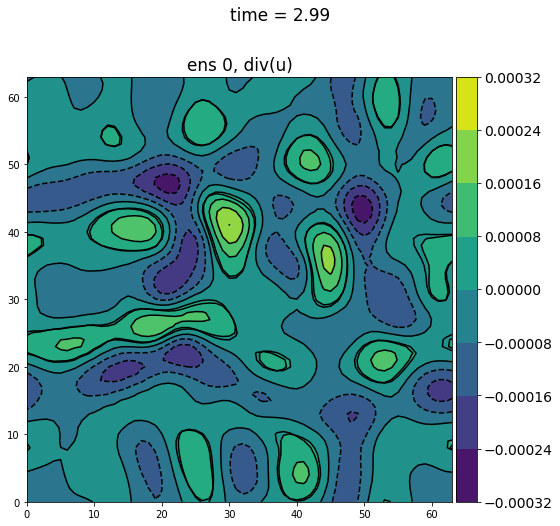

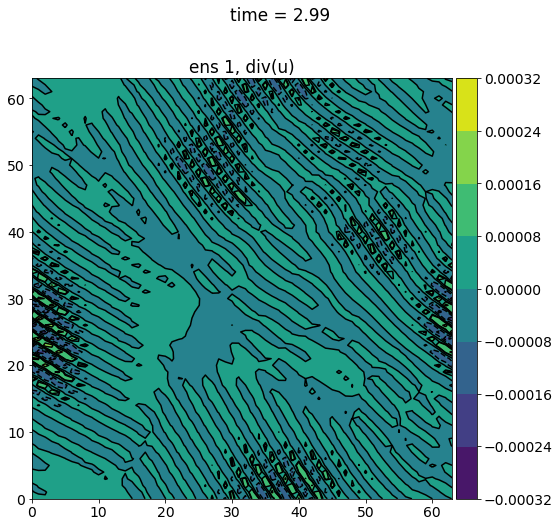

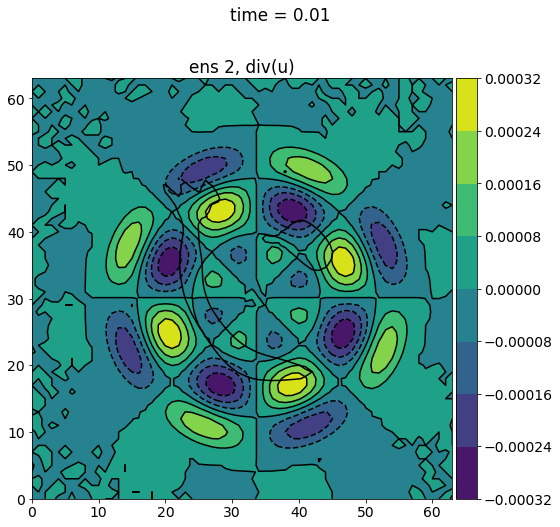

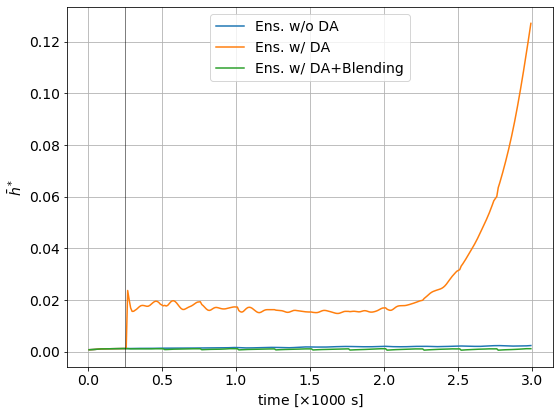

In [3]:
import random
import matplotlib.pyplot as plt

random.seed(444)

N = 10
# sfx0 = 'wdawloc_pp_rhou_rhow_tra_ib_0.25_nonorm'
# sfx0 = 'wdawloc_pp_all_tra_0.25_nonorm'
print("swe =", swe)
if swe:
    sfx0 = 'wdawloc_rhou_rhow_debug_letkf_s10p_ib-0'
    sfx_ref = 'pp_tra_ip_nonorm_ib-0'
    sfx_ref = 'noda_ib-0'
    sfx0 = 'wdawloc_%s_wda_ib-0' %(obs_attrs)
elif rb:
    sfx0 = 'wdawloc_%s_wda_CFLfixed_ib-0' %(obs_attrs)
    sfx_ref = 'noda_CFLfixed_ib-0'
else:
    typ = 'pos'
    sfx0 = 'wdawloc_rhou_rhov_pp_tra_ip_nonorm_ib-0'
    sfx0 = 'wdawloc_rhou_rhov_debug_letkf_s10p_ib-0'
    sfx0 = 'wdawloc_rhou_rhov_debug_%s_s10p_ib-0' %typ
    sfx0 = 'wdawloc_%s_wda_homen_ib-0' %(obs_attrs)
    sfx_ref = 'noda_homen_ib-0'
    sfx0 = 'wdawloc_%s_wda_ib-0' %(obs_attrs)
    sfx_ref = 'noda_ib-0'
#     sfx_ref = 'debug_pos_noda_ib-0'
sfx1 = tc.cb_suffix(1,0, '%s' %(sfx0))

if swe:
    attributes = ['rho','rhou','rhow']
else:
    attributes = ['rho','rhou','rhov','rhoY','p2_nodes']

fn_pickle = tc.get_filename(N,sfx0,format='dat')
path_pickle = tc.get_path(fn_pickle)

file = open(path_pickle,'rb')
ud = pickle.load(file)
elem = pickle.load(file)
node = pickle.load(file)
file.close()

dx = np.diff(elem.x)[0]
if swe:
    dy = np.diff(elem.z)[0]
else:
    dy = np.diff(elem.y)[0]

times = [0.0]
tag = 'ic'

if rb:
    times = np.arange(1.0,10.1,0.1)[1:]    
else:
    times = np.arange(0.0,3.01,0.01)[1:]
# times = np.arange(0.0,0.30,0.01)[1:]
da_times = np.arange(0.0,3.25,0.25)[1:]
times = np.setdiff1d(times,da_times)
# print(times)
tag = tags[9]

class oo(object): pass
ens0_oo = oo()
ens1_oo = oo()
ens_ref_oo = oo()

def get_ens_by_attr(times, N, attributes, sfx, tag=tag, inner=True):
    obj = oo()
    for attribute in attributes:
#         print(attribute)
        ens = tc.get_ensemble(times, N, attribute, sfx, tag=tag, inner=False)#[-1]
#         print(ens.shape)
#         if swe: ens = [mem[:,0,:] for mem in ens]
        ens_cp = np.zeros_like(ens)
        if swe: ens_cp = ens_cp[:,:,:,0,:]
        for mm, mem in enumerate(ens):
            for at, at_t in enumerate(mem):
                if swe:
                    ens_cp[mm,at] = at_t[:,0,:]
                else:
                    ens_cp[mm,at] = at_t
                
        ens = np.copy(ens_cp)
        
        mean = np.mean(ens,axis=1)
        ens = np.append(ens,mean[:,np.newaxis,...],axis=1)
        setattr(obj,attribute,ens)
    
    ens_u = getattr(obj,attributes[1]) / getattr(obj,'rho')
    ens_v = getattr(obj,attributes[2]) / getattr(obj,'rho')
    setattr(obj, 'u', ens_u)
    setattr(obj, 'v', ens_v)
    
    return obj

def grad(arr,dd,direction,ud):
    dd *= ud.h_ref
    arr *= ud.u_ref
    # get partial derivatives
    if direction == 'x':
        axs = 0
    elif direction == 'y':
        axs = 1
    else:
        assert(0, 'direction unspported')
        
    return np.gradient(arr,dd,axis=axs)

if len(attributes) > 1:
    ens0 = get_ens_by_attr(times,N,attributes,sfx0)
    ens1 = get_ens_by_attr(times,N,attributes,sfx1)
    ens_ref = get_ens_by_attr(times,N,attributes,sfx_ref)

enses = [ens_ref, ens0, ens1]
sfxes = [sfx_ref, sfx0, sfx1]

attr_labels = pt.labels()

if swe:
    Frsq = ud.Msq / 2
    Ma = np.sqrt(ud.Msq)
    Fr = np.sqrt(Frsq) # u / sqrt(gh)
    c = ud.u_ref / Ma
    print(Fr)
else:
    Ma = np.sqrt(ud.Msq)
    c = ud.u_ref / Ma
    print("p_ref / rho_ref =", ud.p_ref/ ud.rho_ref)
    print("c^2 =", c**2)

arr_lst = []
barPu = np.zeros((3,len(times)))

def title_gen(frn):
#     return "frame number = %i" %frn
    return "time = %.2f" %times[frn]

print(dx,dy)
for bb,ens in enumerate(enses):
#     print("===============================")
    print("ens %i" %bb)
#     print("===============================")
    arr_plt = np.empty_like(times, dtype='object')
    
    for tt,time in enumerate(times):
        us, vs = ens.u[tt], ens.v[tt]
        rho = ens.rho[tt][:,2:-2,2:-2]

        divu = np.zeros_like(us)
        divu = divu[:,2:-2,2:-2]
        for ii,uv in enumerate(zip(us,vs)):
            u, v = np.copy(uv[0]), np.copy(uv[1])
            div = grad(u,dx,'x',ud) + grad(v,dy,'y',ud)
            divu[ii] = div[2:-2,2:-2]
        
        arr_plt[tt] = [[divu[0],'ens %i, div(u)' %bb]]
            
        if swe:
            Ptu = divu * 0.5 * 11.0 * dx * ud.h_ref / (np.sqrt(9.81 * ud.d_ref)) #* Fr) / ud.h_ref * ud.d_ref
#             Ptu = divu * ud.t_ref * 0.5 * 11.0 * dx * Fr
            Ptu *= rho #* ud.d_ref
        else:
            Ptu = divu * rho * c**2 * ud.rho_ref
            Ptu *=  0.5*11.0*dx * ud.h_ref * Ma / ud.u_ref
            Ptu /= ud.p_ref
            
        Ptu_norm = np.array([ np.sqrt((mem**2).mean()) for mem in Ptu[:-1]]).mean()
        if swe:
            barPu[bb,tt] = Ptu_norm
        else:
            barPu[bb,tt] = Ptu_norm * 1.0/1.4
            
    fs = (8,8)
    a2d = pt.animator_2D(arr_plt,ncols=1,figsize=fs)
    a2d.suptitle = title_gen
    a2d.method = 'contour'
    anim = a2d.animate(interval=500, aspect='equal', method='contour')
    
    import matplotlib.animation as animation

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=10, metadata=dict(artist='Ray Chew'), bitrate=6000)
    anim.save('./output/test_%i.mp4' %bb, writer=writer)
# print(ud.Msq)

t_axs = times

import matplotlib.pyplot as plt

barPu00 = barPu[0][0]
barPu00 = 0.0

plt.figure(figsize=(8,6))

plt.plot(t_axs, barPu[0] - barPu00, label=r'Ens. w/o DA')
plt.plot(t_axs, barPu[1] - barPu00, label=r'Ens. w/ DA')
plt.plot(t_axs, barPu[2] - barPu00, label=r'Ens. w/ DA+Blending')
plt.axvline(0.25, c='k', lw=0.5)

if swe:
    plt.xlabel(r'time [$\times 1000$ s]', labelpad=5)
    plt.ylabel(r'$\nabla \cdot \vec{u}^*$')
    plt.ylabel(r'$\bar{h}^*$')
else:
    plt.xlabel(r'time $[\times 100s]$')
    plt.ylabel(r'$\bar{P}^*$')
# plt.xlim([0.0,3.0])
plt.legend()
plt.grid()
plt.tight_layout()
typ = 'pos' if 'pos' in sfx0 else 'neg'
plt.savefig('./output/bar_P_swe.pdf')
plt.show()

# Effective Mach number calculations

TypeError: Input must be a 2D array.

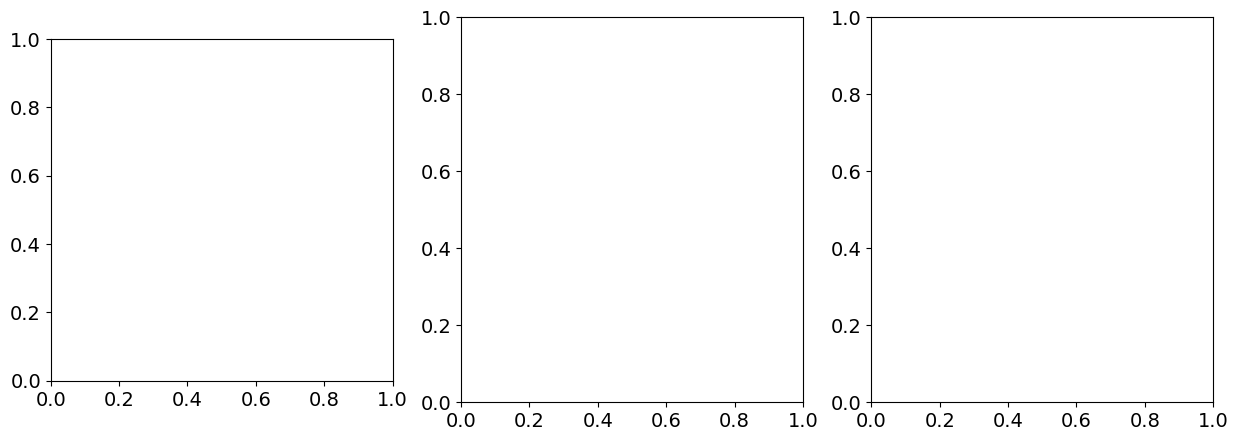

In [220]:
swe = True

attributes = ['rho','rhou','rhov']
et = 3.0
N = 10

if swe:
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    py_directory = "../%s/" %directory

    Nx, Ny, Nz = 64, 1, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
else:
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    py_directory = "../%s/" %directory

    Nx, Ny = 64, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)


sfx0 = 'wdawloc_rhou_rhov_debug_pos_s10p_ib-0'
sfx0 = 'wdawloc_%s_wda_ib-0' %(obs_attrs)
sfx1 = tc.cb_suffix(1,0, '%s' %(sfx0))
sfxes = [sfx0,sfx1]
times_bef = np.arange(0.0,3.25,0.25)[1:-1]
times_aft = 0.01 + times_bef
l_typ = 'TIME'
tag = tc.get_tag_dict()[9]

prt = utils.prt_time(debug=False)
attr_labels = pt.labels_increment()

fn_pickle = tc.get_filename(N,sfx1,format='dat')
path_pickle = tc.get_path(fn_pickle)

file = open(path_pickle,'rb')
ud = pickle.load(file)
file.close()

def get_ens(tc, sfx , diff, attribute):
    tag_aft = tc.get_tag_dict()[9]
    tag_bef = 'before_da'
    
    bef = get_ens_by_attr(times_bef, N, attributes, sfx, tag_bef)
    aft = get_ens_by_attr(times_aft, N, attributes, sfx, tag_aft)

    return bef, aft

class oo(object): None
    
def get_ens_by_attr(times, N, attributes, sfx, tag=tag):
    obj = oo()
    for attribute in attributes:
        ens = tc.get_ensemble(times, N, attribute, sfx, tag=tag)[1:]
        
#         print(ens.shape, tag)
        ens_cp = np.zeros_like(ens)
        for mm, mem in enumerate(ens):
            for at, at_t in enumerate(mem):
                ens_cp[mm,at] = at_t.T

        ens = np.copy(ens_cp)
        
        mean = np.mean(ens,axis=1)
#         ens = np.append(ens,mean[:,np.newaxis,...],axis=1)
        setattr(obj,attribute,ens)
    
    ens_u = getattr(obj,attributes[1]) / getattr(obj,'rho')
    ens_v = getattr(obj,attributes[2]) / getattr(obj,'rho')
    setattr(obj, 'u', ens_u)
    setattr(obj, 'v', ens_v)
    
    return obj

Ms = np.zeros((2,len(times_bef)))

calc_max = True
for ee, sfx in enumerate(sfxes):
    bef, aft = get_ens(euler_tc, sfx, diff, attribute)

    # get mean velocity difference
    mv, mu = np.zeros_like(times_bef), np.zeros_like(times_bef)
    mvs, mus = np.zeros((N)), np.zeros((N))
    bumax, bvmax = 0.0, 0.0
    for tt,time in enumerate(times_bef):
        bu,bv = bef.rhou[tt], bef.rhov[tt]
        au,av = aft.rhou[tt], aft.rhov[tt]
#         bu,bv = bef.u[tt], bef.v[tt]
#         au,av = aft.u[tt], aft.v[tt]
        
        bu, bv = bu / ud.rho_ref, bv / ud.rho_ref
        au, av = au / ud.rho_ref, av / ud.rho_ref

#         bum = np.abs(bu.max())
#         bvm = np.abs(bv.max())

        du = np.array([np.abs(aum - bum) for aum, bum in zip(au,bu)])
        dv = np.array([np.abs(avm - bvm) for avm, bvm in zip(av,bv)])
    
#         mus = np.array([np.abs(aum.max() - bum.max()) for aum, bum in zip(au,bu)])
#         mvs = np.array([np.abs(avm.max() - bvm.max()) for avm, bvm in zip(av,bv)])
        cnt = 0
        for aum, bum in zip(au,bu):
#             aum = np.abs(aum)
#             bum = np.abs(bum)
#             max_diff = np.abs(aum.max() - bum.max())
#             mus = max_diff
#             min_diff = np.abs(aum.min() - bum.min())
#             mus = max_diff + min_diff
            bef_range = bum.max() - bum.min()
            aft_range = aum.max() - aum.min()
            mus[cnt] = np.abs(aft_range - bef_range)
            cnt += 1
            
        cnt = 0
        for avm, bvm in zip(av,bv):
#             avm = np.abs(avm)
#             bvm = np.abs(bvm)
#             max_diff = np.abs(avm.max() - bvm.max())
#             mvs = max_diff
#             min_diff = np.abs(avm.min() - bvm.min())
#             mvs = max_diff + min_diff
            bef_range = bvm.max() - bvm.min()
            aft_range = avm.max() - avm.min()
            mvs[cnt] = np.abs(aft_range - bef_range)
            cnt += 1
            
#         print(mus)
            
        if tt == 0:
            for mm, mem_du in enumerate(du):
                if mm == 0:
#                     arr_lst = [[bef.rhou[tt][mm],'bef'],[aft.rhov[tt][mm],'aft'],[mem_du,'abs diff']]
                
                    arr_lst = [[bu[mm],'bef'],[au[mm],'aft'],[divu[0],'abs diff']]
                    ncolslen = 3
                    fs = (15,5)
                    pl = pt.plotter(arr_lst,ncols=ncolslen,figsize=fs,sharey=False)
                    _ = pl.plot(aspect='equal',method='contour')

        # calculate rel. Mach
        if calc_max:
#             mu[tt] = du.max() * ud.u_ref
#             mv[tt] = dv.max() * ud.u_ref
            mu[tt] = mus.mean() * ud.u_ref
            mv[tt] = mvs.mean() * ud.u_ref
#             bum *= ud.u_ref
#             bvm *= ud.u_ref
#             c = (bum**2 + bvm**2)**0.5 / np.sqrt(ud.Msq)
#             print(du.max(),dv.max(), (du.max()**2 + dv.max()**2)**0.5)
#         else:
#             mu[tt] = du.mean() * ud.u_ref
#             mv[tt] = dv.mean() * ud.u_ref

        c = ud.u_ref / np.sqrt(ud.Msq)

#         Ms[ee,tt] = (mu[tt]**2 + mv[tt]**2)**0.5 / c
        Ms[ee,tt] = (mu[tt] + mv[tt])*0.5 / c
    
# print(ud.Msq)
# print(np.sqrt(ud.Msq))
# print(Ms)


import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
# barPu = np.array(barPu) * 0.1
plt.plot(times_bef, Ms[0], '-o', label=r'wDA')
plt.plot(times_bef, Ms[1], '-o', label=r'wDAB')
# plt.plot(t_axs,barPv, label=r'$\bar{p}_{[v]}^*$')
plt.axvline(0.25, c='k', lw=0.5)
plt.xlim([0.0,3.0])
plt.xlabel(r'time $[\times 100s]$')
plt.ylabel(r'$\mathrm{Ma}_{rel}$')
plt.legend()
# plt.plot(barPuv)
plt.grid()
plt.tight_layout()
    
typ = 'pos' if 'pos' in sfx1 else 'neg'
cmax = 'max' if calc_max else 'mean'
# plt.savefig('relMa_%s_%s.pdf' %(typ,cmax),bbox_inches='tight')
plt.show()

print(Ms[0].mean())
print(Ms[1].mean())

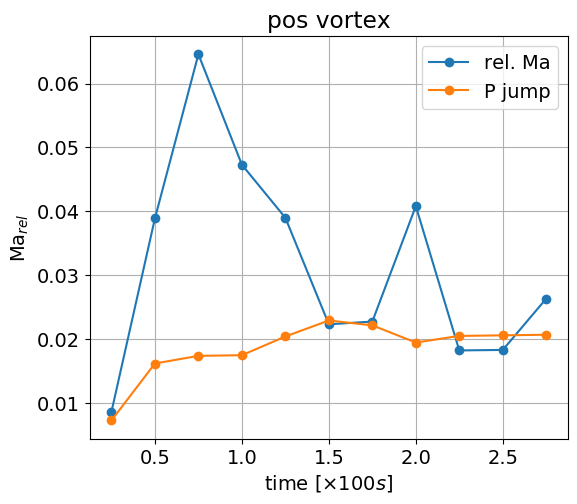

In [124]:
rhoY_error = np.copy(rhoY_err)

Hjump = rhoY_error[25:][::25]
# Hjump = np.append(Hjump,rhoY_error[-1])
Hjump00 = rhoY_error[24]
Hjump -= Hjump00

plt.figure(figsize=(6,5))
# barPu = np.array(barPu) * 0.1
t_axs = np.arange(0.25,3.25,0.25)[:-1]

plt.plot(t_axs, Ms[0], '-o', label=r'rel. Ma')
plt.plot(t_axs, Hjump, '-o', label=r'P jump')
# plt.plot(times, Ms[1], '-o', label=r'wDAB')s
# plt.plot(t_axs,barPv, label=r'$\bar{p}_{[v]}^*$')
# plt.axvline(0.25, c='k', lw=0.5)
# plt.xlim([0.0,3.0])
plt.xlabel(r'time $[\times 100s]$')
plt.ylabel(r'$\mathrm{Ma}_{rel}$')
plt.legend()
# plt.plot(barPuv)
plt.grid()
plt.tight_layout()
    
typ = 'pos' if 'pos' in sfx1 else 'neg'
plt.title('%s vortex' %typ )
cmax = 'max' if calc_max else 'mean'
plt.savefig('%s_relMa_P-jump.pdf' %(typ),bbox_inches='tight')
plt.show()

# Test travelling vortex pressure shift

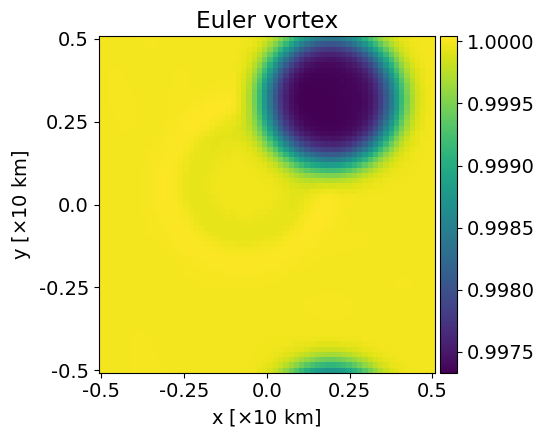

In [144]:
attribute = 'rho'
attribute = 'p2_nodes'
attribute = 'rhoY'
et = 3.0

base_fn = "output_swe_vortex"
directory = "output_swe_vortex"
py_directory = "../%s/" %directory

Nx, Ny, Nz = 64, 1, 64
swe_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)

base_fn = "output_travelling_vortex"
directory = "output_travelling_vortex"
py_directory = "../%s/" %directory

Nx, Ny = 64, 64
euler_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

# times = np.arange(0,176)#[:50]
times = [0.25]
l_typ = 'TIME'

prt = utils.prt_time(debug=False)
attr_labels = pt.labels_increment()

def get_ens(tc, sfx , diff, attribute, swe=True):
    ens = tc.get_ensemble(times, 1, attribute, sfx, label_type=l_typ, avg=True, diff=diff)[1]
    if swe: ens = ens[:,0,:]
#     ens *= 10.0

    label = sfx + '_' + attribute
    return label, ens

diff = False

swe = False
if swe:
    sfx1 = 'pos_debug'
    l1, a1 = get_ens(swe_tc, sfx1, diff, attribute,swe=True)
    la = 'SWE_vortex'
    aa = a1
    lvls = np.arange(-0.0155,0.0035,0.0030) * 10.0
else:
    sfx1 = 'pos_debug'
    sfx1 = 'neg_debug'
    sfx1 = 'obs_homen'
    l2, a2 = get_ens(euler_tc, sfx1, diff, attribute, swe=False)
    la = 'Euler vortex'
    aa = a2
    lvls = np.arange(-0.0065,0.0015,0.0010) * 10.0
    
ll = [aa, la]
pl_lst = [ll]

pl = pt.plotter(pl_lst,ncols=1,figsize=(10,5),sharey=False)
x_axs = [-0.5,-0.25,0.0,0.25,0.5]
y_axs = [-0.5,-0.25,0.0,0.25,0.5]
x_loc = np.linspace(0,Nx-1,5)
y_loc = np.linspace(0,Nz-1,5)
if swe: 
    x_label = r'x [km]'
    y_label = r'y [km]'
else:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'

pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
_ = pl.plot(aspect='equal',method='imshow')
pl.save_fig('./output/euler_imprint')